# Data Preprocessing

MBTI and Writing Style

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Imports to be used.

In [2]:
# !pip install ftfy

     |████████████████████████████████| 71kB 5.6MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41916 sha256=9d03a54b479889a3b6a8a4719773142ff4cf16753ed77e2b0714201baa4b43f1
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [1]:
from ftfy import fix_encoding
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math
import csv
import string
import re
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import plot_importance

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier

from collections import Counter
import wordcloud
import itertools
import collections
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

pd.set_option('max_rows',1000000)
pd.set_option('max_columns',10000)
sns.set(rc={'figure.figsize':(15,10)})

# %load_ext autoreload
# %autoreload 2

In [3]:
def fix_encode(x):
  return fix_encoding(x)


# reads the csv file and converts it into a pandas dataframe
raw_data = pd.read_csv(
    'Data/mbti_1.csv',
    encoding="utf-8",
    quoting=csv.QUOTE_ALL
    )
print("Shape of the raw data", raw_data.shape)

# displays the first 5 entries
raw_data.head()

Shape of the raw data (8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
raw_data["posts"] = raw_data["posts"].apply(lambda x: fix_encode(x))

## EDA

We separate each MBTI letter type classification -- which technically can be called binary classifications -- so, for example: an INTJ type would have a value of '1' on all columns (`IE`, `NS`, `TF`, `JP`). 

This allows us to explore each MBTI personality type index or axis.

In [5]:
def get_types(row):
  t=row['type']

  I = 0; N = 0
  T = 0; J = 0
  
  if t[0] == 'I': I = 1
  elif t[0] == 'E': I = 0
  else: print('I-E not found') 
      
  if t[1] == 'N': N = 1
  elif t[1] == 'S': N = 0
  else: print('N-S not found')
      
  if t[2] == 'T': T = 1
  elif t[2] == 'F': T = 0
  else: print('T-F not found')
      
  if t[3] == 'J': J = 1
  elif t[3] == 'P': J = 0
  else: print('J-P not found')
  return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

raw_data = raw_data.join(raw_data.apply(lambda x: get_types(x), axis=1))
raw_data.head()

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [6]:
print ("Introversion (I) /  Extroversion (E):\t", raw_data['IE'].value_counts()[0], " / ", raw_data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", raw_data['NS'].value_counts()[0], " / ", raw_data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", raw_data['TF'].value_counts()[0], " / ", raw_data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", raw_data['JP'].value_counts()[0], " / ", raw_data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


From this, we can gather that there is unequal distribution in `IE` and `NS`. `TF` and `JP` have less difference.

---



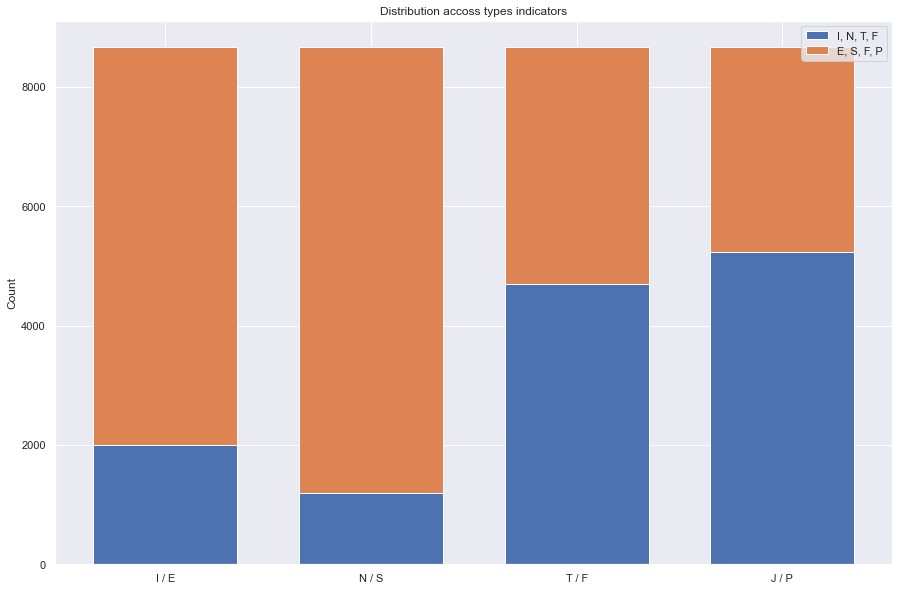

In [8]:
N = 4
bottom = (raw_data['IE'].value_counts()[0], raw_data['NS'].value_counts()[0], raw_data['TF'].value_counts()[0], raw_data['JP'].value_counts()[0])
top = (raw_data['IE'].value_counts()[1], raw_data['NS'].value_counts()[1], raw_data['TF'].value_counts()[1], raw_data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.savefig('Figures/mbti-types-distribution.png',bbox_inches = 'tight', dpi=100)
plt.show()

In [9]:
raw_data[['IE', 'NS', 'TF', 'JP']].corr()

,IE,NS,TF,JP
IE,1.000000,-0.045899,-0.069573,0.161939
NS,-0.045899,1.000000,-0.080954,0.014922
TF,-0.069573,-0.080954,1.000000,-0.004673
JP,0.161939,0.014922,-0.004673,1.000000


From this, there is not much we can give as evidence that each type index is  significantly correlated (either positively or negatively) with other types -- in other words, an assumption may be made that each [letter] type index is independent of other type indices.

---

We can plot a heat map (or a correlation matrix) to visualize our table above.

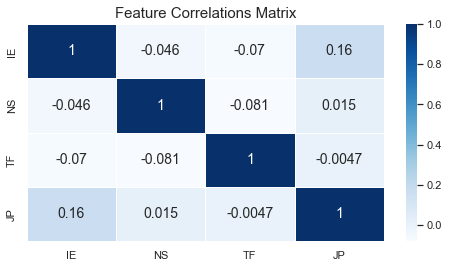

In [10]:
cmap = plt.cm.Blues
corr = raw_data[['IE', 'NS', 'TF', 'JP']].corr()
plt.figure(figsize = (8, 4))
plt.title('Feature Correlations Matrix', size = 15)
sns.heatmap(corr, cmap=cmap, annot=True, linewidths=1, annot_kws={"size": 14})
plt.savefig('Figures/mbti-heatmap.png',bbox_inches = 'tight', dpi=100)

## Data Pre-processing

In this sub-section, we binarize each letter type, as we initially visualized earlier during our EDA phase (e.g., I = 0, E = 1).

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
lemmatizer = WordNetLemmatizer()

stop_words = stopwords.words('english')

mbti_types = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

mbti_types = [x.lower() for x in mbti_types]

In [13]:
bin_pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
bin_pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [bin_pers[l] for l in personality]

def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += bin_pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in raw_data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


Now in this section, we clean the `posts` column.

In [14]:
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0
  
  for row in data.iterrows():
      # check code working 
      # i+=1
      # if (i % 500 == 0 or i == 1 or i == len_data):
      #     print("%s of %s rows" % (i, len_data))

      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatizer.lemmatize(w) for w in temp.split(' ') if w not in stop_words])
      else:
          temp = " ".join([lemmatizer.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in mbti_types:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(raw_data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", raw_data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", raw_data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [15]:
nRow, nCol = list_personality.shape
print(f'No. of posts = {nRow}  and No. of Personalities = {nCol} ')

No. of posts = 8675  and No. of Personalities = 4 


## Feature Engineering

---

Aside from `CountVectorizer()` which uses frequency counts, we also will use `TfidfVectorizer()` which measures the relevancy of the word to a document in a corpus.

We set the maximum and minimum bounds in which a term or word is relevant (`max_df` and `min_df`, respectively).

In [16]:
tfidfvectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_df=0.7, min_df=0.1)

train = tfidfvectorizer.fit_transform(list_posts)

In [17]:
train.shape

(8675, 595)

In [18]:
feature_names = list(enumerate(tfidfvectorizer.get_feature_names()))
feature_names[:25]

c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[(0, 'ability'),
 (1, 'able'),
 (2, 'absolutely'),
 (3, 'across'),
 (4, 'act'),
 (5, 'action'),
 (6, 'actually'),
 (7, 'add'),
 (8, 'advice'),
 (9, 'afraid'),
 (10, 'age'),
 (11, 'ago'),
 (12, 'agree'),
 (13, 'almost'),
 (14, 'alone'),
 (15, 'along'),
 (16, 'already'),
 (17, 'also'),
 (18, 'although'),
 (19, 'always'),
 (20, 'amazing'),
 (21, 'amount'),
 (22, 'angry'),
 (23, 'another'),
 (24, 'answer')]

In English, this means we have 595 features per user [post].



## Model Building

For reference:
* X - TFIDF representation of user posts
* Y - Personality type in Binarized MBTI Form

In [19]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [20]:
print("X: 1st posts in tf-idf representation\n%s" % train[0])

X: 1st posts in tf-idf representation
  (0, 349)	0.059410348139259946
  (0, 489)	0.06502346132069718
  (0, 338)	0.08813151493295181
  (0, 565)	0.041111781914928196
  (0, 52)	0.07087570430581895
  (0, 51)	0.05506308219879645
  (0, 277)	0.09349615314377653
  (0, 481)	0.07466644149972529
  (0, 11)	0.07066064469623083
  (0, 590)	0.04833236437892714
  (0, 485)	0.09843693837709419
  (0, 10)	0.0810547840560131
  (0, 222)	0.08435344092094439
  (0, 340)	0.07177947503220493
  (0, 441)	0.06318281551598931
  (0, 366)	0.06973745829337154
  (0, 261)	0.055577348034995554
  (0, 457)	0.08311160014717112
  (0, 276)	0.07930796829118913
  (0, 433)	0.08968055824148229
  (0, 510)	0.08067849379801398
  (0, 406)	0.09901670503451844
  (0, 450)	0.06642087294200923
  (0, 383)	0.09674118343306329
  (0, 243)	0.056315768105070226
  :	:
  (0, 192)	0.293044846811719
  (0, 499)	0.06869091772866434
  (0, 568)	0.1643469482973132
  (0, 218)	0.05834299082379839
  (0, 171)	0.08435344092094439
  (0, 544)	0.10580776947921257

In [21]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


---

We now go to the training proper. Note that we are essentially training classifiers on *each* personality type index; hence, the for-loop.

We use the same algorithms as before. 

In [22]:
X = train

### XG Boost

In [23]:
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    # accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)

    print("%s" % (personality_type[l]))
    print(report)

IE: Introversion (I) / Extroversion (E)
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      2662
           1       0.36      0.08      0.13       808

    accuracy                           0.75      3470
   macro avg       0.57      0.52      0.49      3470
weighted avg       0.68      0.75      0.69      3470

NS: Intuition (N) / Sensing (S)
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2986
           1       0.39      0.03      0.05       484

    accuracy                           0.86      3470
   macro avg       0.63      0.51      0.49      3470
weighted avg       0.80      0.86      0.80      3470

FT: Feeling (F) / Thinking (T)
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1858
           1       0.66      0.60      0.63      1612

    accuracy                           0.67      3470
   macro avg       0.67  

### Logistic Regression

In [24]:
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)

    # fit model on training data
    model = LogisticRegression(solver='lbfgs') 
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    # accuracy = accuracy_score(y_test, predictions)
    # print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    report = classification_report(y_test, predictions)

    print("%s" % (personality_type[l]))
    print(report)

IE: Introversion (I) / Extroversion (E)
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      2662
           1       0.50      0.07      0.12       808

    accuracy                           0.77      3470
   macro avg       0.64      0.52      0.49      3470
weighted avg       0.71      0.77      0.69      3470

NS: Intuition (N) / Sensing (S)
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2986
           1       0.60      0.01      0.02       484

    accuracy                           0.86      3470
   macro avg       0.73      0.51      0.47      3470
weighted avg       0.83      0.86      0.80      3470

FT: Feeling (F) / Thinking (T)
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      1858
           1       0.72      0.67      0.70      1612

    accuracy                           0.73      3470
   macro avg       0.73  

### SVM

In [25]:
# SVM model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)

    # fit model on training data
    model = SVC(random_state = 101)
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    # print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    report = classification_report(y_test, predictions)

    print("%s" % (personality_type[l]))
    print(report)

IE: Introversion (I) / Extroversion (E)
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2662
           1       0.67      0.01      0.01       808

    accuracy                           0.77      3470
   macro avg       0.72      0.50      0.44      3470
weighted avg       0.74      0.77      0.67      3470



c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

NS: Intuition (N) / Sensing (S)
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2986
           1       0.00      0.00      0.00       484

    accuracy                           0.86      3470
   macro avg       0.43      0.50      0.46      3470
weighted avg       0.74      0.86      0.80      3470

FT: Feeling (F) / Thinking (T)
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1858
           1       0.73      0.67      0.70      1612

    accuracy                           0.73      3470
   macro avg       0.73      0.73      0.73      3470
weighted avg       0.73      0.73      0.73      3470

JP: Judging (J) / Perceiving (P)
              precision    recall  f1-score   support

           0       0.59      0.31      0.41      1354
           1       0.66      0.86      0.75      2116

    accuracy                           0.65      3470
   macro avg       0.62      0.5

## MNB

In [27]:
from sklearn.naive_bayes import MultinomialNB

# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)

    # fit model on training data
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    # accuracy = accuracy_score(y_test, predictions)
    
    # print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    report = classification_report(y_test, predictions)

    print("%s" % (personality_type[l]))
    print(report)

IE: Introversion (I) / Extroversion (E)
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2662
           1       0.00      0.00      0.00       808

    accuracy                           0.77      3470
   macro avg       0.38      0.50      0.43      3470
weighted avg       0.59      0.77      0.67      3470

NS: Intuition (N) / Sensing (S)
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2986
           1       0.00      0.00      0.00       484

    accuracy                           0.86      3470
   macro avg       0.43      0.50      0.46      3470
weighted avg       0.74      0.86      0.80      3470

FT: Feeling (F) / Thinking (T)
              precision    recall  f1-score   support

           0       0.65      0.87      0.75      1858
           1       0.76      0.46      0.57      1612

    accuracy                           0.68      3470
   macro avg       0.70  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# With Data Augmentation

In [26]:
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
import random

In [27]:
def create_dataset(n_sample=1000):
    ''' 
    Create a unevenly distributed sample data set multilabel  
    classification using make_classification function
    
    args
    nsample: int, Number of sample to be created
    
    return
    X: pandas.DataFrame, feature vector dataframe with 10 features 
    y: pandas.DataFrame, target vector dataframe with 5 labels
    '''
    X, y = make_classification(n_classes=5, class_sep=2,
                               weights=[0.1,0.025, 0.205, 0.008, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                               n_features=10, n_clusters_per_class=1, n_samples=1000, random_state=10)
    y = pd.get_dummies(y, prefix='class')
    return pd.DataFrame(X), y
    
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [28]:
X, y = create_dataset()  # Creating a Dataframe
X_sub, y_sub = get_minority_samples(X, y)  # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 100, 5)  # Applying MLSMOTE to augment the dataframe

In [29]:
y.value_counts()

class_0  class_1  class_2  class_3  class_4
0        0        0        0        1          662
                  1        0        0          205
1        0        0        0        0          100
0        1        0        0        0           25
         0        0        1        0            8
dtype: int64

In [30]:
raw_data.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [31]:
y_res.head()

,class_0,class_1,class_2,class_3,class_4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
